This notebook introduces SMOTE (first published in Chawla, Bowyer, Hall, & Kegelmeyer, 2002, "SMOTE: synthetic minority over-sampling technique," Journal of Artificial Intelligence Research) to synthetically generate additional observations in the case of an imbalanced dataset. The notebook is self-contained.


We start by creating our "original" dataset, where only 1% of observations belong to the minority class (`y=1`):

In [64]:
from sklearn.datasets import make_classification
import numpy as np

X,y = make_classification(n_samples=11000, n_features=2, n_redundant=0,n_classes=2,n_clusters_per_class=1, weights=[0.99,0.01], flip_y=0, random_state=123)

In [65]:
print(X.shape)
print(y.shape)
print(np.sum(y))

(11000, 2)
(11000,)
110


We split the data into train and test sets. We will later build also a validation set, using both original and synthetic data. However, it is key that the test set only contains the original data! Because there are only few datapoints with `y=0`, we need to have a big enough test set.

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=503)

In [67]:
np.sum(y_test)

32

We also normalize the data (remember, whether you do this always depends on your data and application, but it is generally recommended when you do synthetic data generation).

Keep in mind to only use the training data to fit the scaler, and then apply it to the test data. Of course, we would optimally do the scaling after the validation set has been split off, but that would mean we have to run SMOTE on un-scaled data, which can be a suboptimal, as well. Hence, we choose what we think is the lesser evil.

In [68]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using only SMOTE

To run SMOTE, we use the `imblearn` package (install with `pip install imbalanced-learn`). Additionally, we can make the process easier with the `collections` package, which will usually already be installed with `imblearn`. Finally, we will do some plotting, so we use `matplotlib`.

In [69]:
import imblearn
from collections import Counter
import matplotlib.pyplot as plt

We now run SMOTE on the our sample. We use the parameter `sampling_strategy=0.1` to specify that our resulting dataset should have 10% of minority class observations. The `random_state` variables, as always, makes things reproducible. You can find more information in the [documentation](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html).

In [70]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state = 483)
X_synth, y_synth = smote.fit_resample(X_train, y_train)

Let's plot both the original dataset and the one with synthetically generated data.

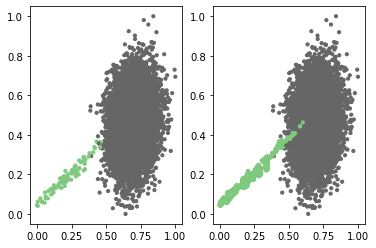

In [71]:
plt.subplot(1,2,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap="Accent_r")
plt.subplot(1,2,2)
plt.scatter(X_synth[:, 0], X_synth[:, 1], c=y_synth, s=10, cmap="Accent_r")

As you can see, the data is quite clustered (by design). And SMOTE generates new data in approximately the area where we would estimate observations with `y=1` to be. Of course, if you have more than 2 features, such clustering might not be directly visible on a 2D-plot.

Take a look at the shapes and sizes of the original y vector and the synthetically enhanced one:

In [72]:
print(y_train.shape)
print(np.sum(y_train))

print(y_synth.shape)
print(np.sum(y_synth))

(8250,)
78
(8989,)
817


# Using SMOTE and undersampling

The spelling of sampling_strategy is incorrect in sampling_startegy=0.2.   It should be sampling_strategy=0.2.
You have written 10% minority class observations which is a bit ambiguous.   It would be clearer to say that the SMOTE sampler is configured to oversample the minority class until it constitutes 10% of the dataset.
For the RandomUnderSampler, the explanation is a bit unclear.   The sampling_strategy=0.2 implies that after undersampling, the minority class will constitute 20% of the observations, not that you'll end up with 20% of the observations in the minority class.   This is because sampling_strategy refers to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling.
You should specify that the Pipeline will execute the oversampling and undersampling sequentially to reach the desired distribution of classes.

It is generally recommended to combine SMOTE (synthetically generating minority class observations) with "undersampling" of the majority class, that is, with also leaving out some of the observations with `y=0`. We will show how to do this here, but the process is quite similar.

We start with creating a SMOTE sampler as before (specifying that the resulting dataset should have 10% minority class observations. We then add a `RandomUnderSampler`, using `sampling_startegy=0.2` to specify that we only want as many observations from the majority class, that we end up with 20% of our observations in the minority class. We use a `Pipeline` to combine the steps:

In [73]:
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state = 483)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.2, random_state = 241)
steps = [('o', over), ('u', under)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)
X_synth, y_synth = pipeline.fit_resample(X_train, y_train)

As before, we can visualize the process:

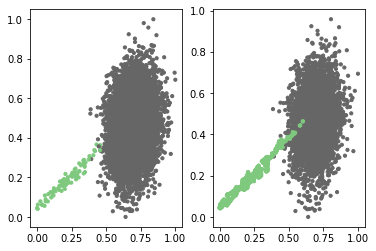

In [74]:
plt.subplot(1,2,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap="Accent_r")
plt.subplot(1,2,2)
plt.scatter(X_synth[:, 0], X_synth[:, 1], c=y_synth, s=10, cmap="Accent_r")

The main change is that we haven't just added synthetic data with `y=0`, we have also removed original data with `y=1`. This can be seen by looking at the y's as before:

In [75]:
print(y_train.shape)
print(np.sum(y_train))

print(y_synth.shape)
print(np.sum(y_synth))

(8250,)
78
(4902,)
817


We now have a modified dataset `(X_train,y_train)`, which we can split into train and validation to find a good model. Once we have decided on a model, we use the (non-enhanced) `(X_test,y_test)` to evaluate the model. Keep in mind that you can always change the `sampling_strategy` parameters of both SMOTE and the undersampling (or even remove undersampling completely, if you find this to work out better).